# Optimization Homework 3
Here are just some simple codes for the homework.
I follow [Numerical Recipes in C](https://www.cec.uchile.cl/cinetica/pcordero/MC_libros/NumericalRecipesinC.pdf)
for the overall algorithm.

For the first part of the problem we find the linear approximation of this set of points.

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import line_search
from sklearn.linear_model import LinearRegression # For comparision

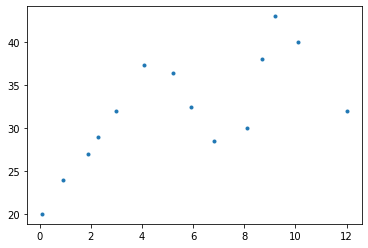

In [88]:
X = np.array([0.1, 0.9, 1.9, 2.3, 3, 4.1, 5.2, 5.9, 6.8, 8.1,
    8.7, 9.2, 10.1, 12])
Y = np.array([20, 24, 27, 29, 32, 37.3, 36.4, 32.4, 28.5,
             30, 38, 43, 40, 32])
plt.plot(X, Y, '.')

# Variance
In the book they assume that each point has its own variance $\sigma_i$, but here we just use the same $\sigma$ for all the points.

The terms of the formula are:
$$ S = \sum_{i=1}^{N}\frac{1}{\sigma^2_i}\quad S_x=\sum_{i=1}^{N}\frac{x_i}{\sigma^2_i} \quad S_y = \sum_{i=1}^{N}\frac{y_i}{\sigma_i^2}$$
$$S_{xx} = \sum_{i=1}^{N}\frac{x_i^2}{\sigma_i^2}\quad S_{xy}=\sum_{i=1}^{N}\frac{x_i y_i}{\sigma_i^2}$$

In [89]:
def optimize(X, Y):
    m, b = 0, 0
    npoints = X.shape[0]
    iterations = 5
    lr = 0.01
    i = 0
    while i < iterations:
        preds = X * m + b
        dm =(-2/npoints)* np.sum(X * (Y - preds))
        db = (-2/npoints)*(np.sum(Y - preds))
        m -= (dm * lr)
        b -= (db * lr)
        
        i += 1
    return m, b

## Plot the Estimate Line
Initial estimate given arbitrary variance.

4.281364105279622 1.2622328750877394
4.281364105279622 1.2622328750877394
4.281364105279622 1.2622328750877394
4.281364105279622 1.2622328750877394
4.281364105279622 1.2622328750877394


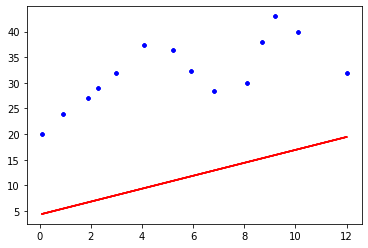

In [90]:
i = 0
while i < 5:
    a, b = optimize(X, Y)
    print(a,b)
    preds = X * b + a
    #var = np.sum(np.power(Y - preds, 2) / (N - M)) 
    #print(var)
    plt.plot(X, Y, 'b.')
    plt.plot(X, preds, 'r')
    i += 1
plt.show()

## `sklearn`'s Linear Regression for comparison

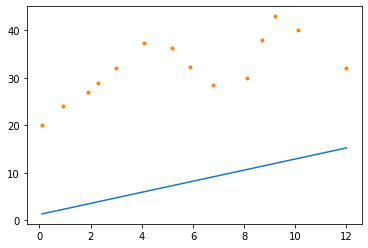

In [91]:
model  = LinearRegression().fit(X.reshape(-1, 1), Y)
plt.plot(X, X * model.coef_ + b)
plt.plot(X, Y, '.')
plt.show()


## Quadratic Regression
The quadratic function is 
$$f(x) = ax^2 + bx + c$$

To find the optimal $(a, b, c)$, we can solve the system of equations
$$ a\sum x_i^4 + b\sum x_i^3 + c\sum x_i^2 = \sum x_i^2 y$$
$$ a\sum x_i^3 + b\sum x_i^2 + c\sum x_i = \sum x_i y$$
$$ a\sum x_i^2 + b\sum x_i + cn_i = \sum y_i$$

We use an online solver to arrive at the optimal values of $a, b, c$.

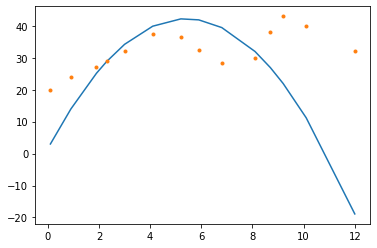

In [92]:
a = -1.4
b = 15.1
c = 1.51
preds = a * np.power(X, 2) + b * X + c

plt.plot(X, preds)
plt.plot(X,Y, '.')
plt.show()

# 2
Using Fletcher-Reeves, and either Newton or Quasi-Newton method, find the best fit linear and quadratic lines numerically.

## Fletcher Reeves


1068.9471428571428
[1.98394315 0.32769679]
[1.97997526 0.3270414 ] [-1.98394315 -0.32769679]
[1.98223415 0.32744799] [-1.07693097 -0.21136251]
[1.97890366 0.32683094] [-1.07589428 -0.21122944]
[1.98332093 0.32766115] [-1.07742377 -0.21142581]
[1.97784468 0.32662286] [-1.07539451 -0.21116524]
[1.98442417 0.32787744] [-1.07791077 -0.21148837]
[1.97680618 0.3264187 ] [-1.07488718 -0.21110008]
[1.98555162 0.32809839] [-1.07838837 -0.21154972]
[1.97579605 0.32622001] [-1.07436872 -0.21103348]
[1.98671103 0.32832551] [-1.07885291 -0.21160939]


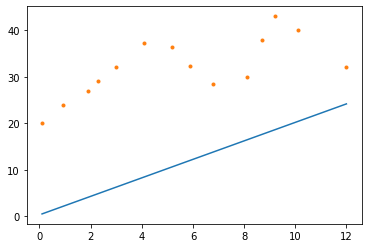

In [158]:
# Quadratic regression error gradient
def error(Y, preds):
    return np.sum(np.power(Y-preds, 2)) / Y.shape[0]

def objective(p, x, y, preds, guess):
    N = x.shape[0]
    preds = p[0] * x + p[1]
    ret =  (1/14) * np.sum(np.power((y - preds), 2))
    print(ret)
    return ret*.000001

def gradient(x, y, preds, guess):
    size = preds.shape[0]
    den = -2 / size
    dyda = np.sum((y - preds)*(x.T * x)) * den
    dydb = np.sum((y - preds)*x) * den
    dydc = np.sum((y-preds)) * den
    return np.array([dyda, dydb, dydc]) / (size * size)

def linear_gradient( x, y, preds, guess):
    size = x.shape[0]
    den = -2/size
    dydw = np.sum((y - preds)*x) *den
    dyda = np.sum((y - preds)) * den
    ret = np.array([dydw, dyda])
    return ret / (size * size)

def get_lambda(guess, S):
    denom = S / np.linalg.norm(S, ord=2)
    a = -guess[0]  * denom
    b = -guess[1] * denom
    c = -guess[2] * denom
    ret =  np.array([np.linalg.norm(a),
                     np.linalg.norm(b),
                     np.linalg.norm(c)]) 
    return ret

tol = 0.5
#Basically get the first iteration
guess = np.array([0, 0])
preds = X * guess[0] + guess[1]

grad = linear_gradient(X, Y, preds, guess)
S = -grad

print(error(Y, preds))
guess = guess + (S)
i = 0
print(S)
# TODO: Still need to find lambda better
while i < 10:
    prev_grad = grad
    grad = linear_gradient(X, Y, preds, guess)
    S = -grad + ((np.power(np.linalg.norm(grad),2))/(np.power(np.linalg.norm(prev_grad),2)))*S

    guess = guess + (lamb * S)
    lamb *= -1
    preds = guess[0] * X + guess[1]
    print(guess, grad)
    i += 1
    
plt.plot(X, preds)
plt.plot(X, Y, '.')

### Fletcher-Reeves on Quadratic Function
The procedure is the same, except we add the quadratic term in our loss function, and our gradient.

664.4330205104947
[0.31493665 0.04062468 0.0070531 ]
457.0204824772045
[0.3726974  0.05055829 0.00942227]
428.00058216171743
[0.3945229  0.0566942  0.01134962]
423.62744318563335
[0.40317375 0.06159407 0.01318277]
422.75620446416843
[0.40760601 0.06689932 0.01533295]
422.3483326337318
[0.41063603 0.07477066 0.01864209]
421.8761618180709
[0.41218886 0.08802362 0.02433285]
421.04314574536085
[0.41076318 0.10896814 0.03345689]
419.5132807478461
[0.40532769 0.13478965 0.04482977]
417.3787733181586
[0.39837295 0.1571643  0.05476142]


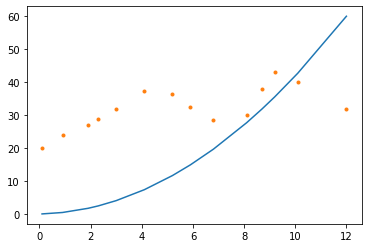

In [176]:
guess = np.array([0, 0, 0]) # Initial point
preds = guess[0] * np.power(X, 2) + guess[1] * X + guess[2]
grad = gradient(X, Y, preds, guess)
S = -grad
lamb = .01
guess = guess +(lamb * S)
i = 0

while i < 10:
    preds = guess[0] * np.power(X, 2) + guess[1] * X + guess[2]
    prev_grad = grad
    grad = gradient(X, Y, preds, guess)
    S = -grad + (np.dot(grad, grad) / np.dot(prev_grad, prev_grad))*S
    #print(lamb.shape, S.shape)
    guess = guess + (lamb * S)
    print(error(Y, preds))
    print(guess)
    i += 1
plt.plot(X, preds)
plt.plot(X, Y, '.')

In [ ]:
## Newton's Method
With Newtons method, we 